# Notebook for the flu ensemble modeling challenge

### Load dependencies

In [106]:
import os
import json
import sympy
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, List, Callable

# MIRA modeling dependencies
from mira.metamodel import *
from mira.metamodel.ops import stratify
from mira.examples.concepts import susceptible, exposed, infected, recovered
from mira.modeling import Model
from mira.modeling.amr.petrinet import AMRPetriNetModel, template_model_to_petrinet_json
from mira.sources.amr.petrinet import template_model_from_amr_json
from mira.metamodel.io import model_to_json_file, model_from_json_file

# PyCIEMSS dependencies
import pyciemss
import pyciemss.visuals.plots as plots
import pyciemss.visuals.vega as vega
import pyciemss.visuals.trajectories as trajectories

### Process data

In [107]:
# Read data
data22_23 = pd.read_csv("FL-PA-Truth-22-23.csv")
data23_24 = pd.read_csv("FL-PA-Truth-23-24.csv")
data23_24 = data23_24.drop(7) # duplicate row in original
data23_24['timezero'] = pd.to_datetime(data23_24['timezero'])

# Filter the data for Florida (FL) and Pennsylvania (PA)
data_fl = data23_24[data23_24['unit'] == 'FL']
data_pa = data23_24[data23_24['unit'] == 'PA']

# Convert from incident to cumulative hospitalizations from 2023-10-14
start_date = pd.Timestamp('2023-10-14')
data_fl = data_fl[data_fl['timezero'] >= start_date]
data_pa = data_pa[data_pa['timezero'] >= start_date]

data_fl['cumulative'] = data_fl['value'].cumsum()
data_pa['cumulative'] = data_pa['value'].cumsum()

### Plot the data

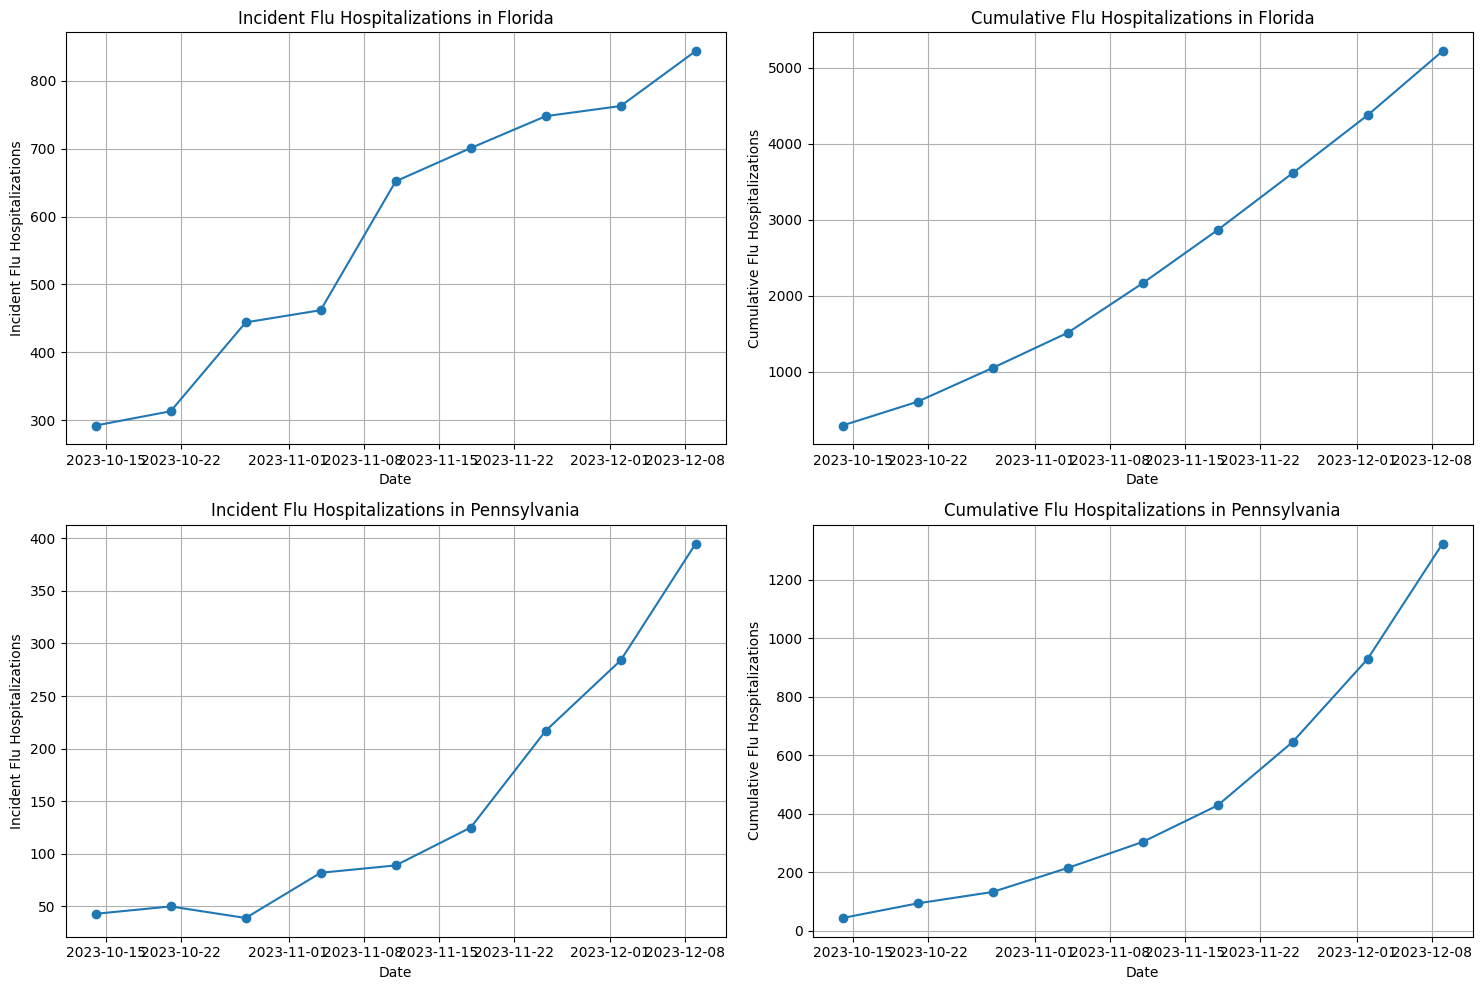

In [108]:
# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plot incident data for Florida (FL)
axs[0, 0].plot(data_fl['timezero'], data_fl['value'], marker='o', linestyle='-')
axs[0, 0].set_title('Incident Flu Hospitalizations in Florida')
axs[0, 0].set_xlabel('Date')
axs[0, 0].set_ylabel('Incident Flu Hospitalizations')
axs[0, 0].grid(True)

# Plot cumulative data for Florida (FL)
axs[0, 1].plot(data_fl['timezero'], data_fl['cumulative'], marker='o', linestyle='-')
axs[0, 1].set_title('Cumulative Flu Hospitalizations in Florida')
axs[0, 1].set_xlabel('Date')
axs[0, 1].set_ylabel('Cumulative Flu Hospitalizations')
axs[0, 1].grid(True)

# Plot incident data for Pennsylvania (PA)
axs[1, 0].plot(data_pa['timezero'], data_pa['value'], marker='o', linestyle='-')
axs[1, 0].set_title('Incident Flu Hospitalizations in Pennsylvania')
axs[1, 0].set_xlabel('Date')
axs[1, 0].set_ylabel('Incident Flu Hospitalizations')
axs[1, 0].grid(True)

# Plot cumulative data for Pennsylvania (PA)
axs[1, 1].plot(data_pa['timezero'], data_pa['cumulative'], marker='o', linestyle='-')
axs[1, 1].set_title('Cumulative Flu Hospitalizations in Pennsylvania')
axs[1, 1].set_xlabel('Date')
axs[1, 1].set_ylabel('Cumulative Flu Hospitalizations')
axs[1, 1].grid(True)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

### Format the data for `PyCIEMSS` and save as a csv for each state

In [109]:
 # Process Florida data
data_fl = data_fl[['cumulative']].rename(columns={'cumulative': 'cumulative_hosp'})
data_fl = data_fl.reset_index(drop=True)
data_fl.index = data_fl.index.astype(float)
data_fl.index.name = 'Timestamp'
data_fl.to_csv("data_fl.csv")

# Process Pennsylvania data
data_pa = data_pa[['cumulative']].rename(columns={'cumulative': 'cumulative_hosp'})
data_pa = data_pa.reset_index(drop=True)
data_pa.index = data_pa.index.astype(float)
data_pa.index.name = 'Timestamp'
data_pa.to_csv("data_pa.csv")

# Print each dataset
print(data_fl)
print(data_pa)

           cumulative_hosp
Timestamp                 
0.0                    292
1.0                    605
2.0                   1049
3.0                   1511
4.0                   2163
5.0                   2864
6.0                   3612
7.0                   4375
8.0                   5219
           cumulative_hosp
Timestamp                 
0.0                     43
1.0                     93
2.0                    132
3.0                    214
4.0                    303
5.0                    428
6.0                    645
7.0                    929
8.0                   1324


## Set Florida and Pennsylvania population parameters and initial values

In [110]:
## Select which state to build the model for: 0 for Florida, 1 for Pennsylvania
state_num = 0 # FLORIDA
# state_num = 1 # PENNSYLVANIA

## Create a dictionary of parameter and initial values for t0 = October 14, 2023
vacc_efficacy = [0.45, 0.48] # [against contracting flu, against hospitalization], source: http://dx.doi.org/10.15585/mmwr.mm7406a2
hosp_rate = 0.008
state_dict = {
    "state_name": ["Florida", "Pennsylvania"],
    "model_name": ["sierh_Florida.json", "seirh_Pennsylvania.json"],
    "dataset": [data_fl, data_pa],
    "dataset_name": ["data_fl.csv", "data_pa.csv"],
    "total_population": [23_370_000, 13_080_000],
    "percent_vacc0": [0.163, 0.24], # percent of adults vaccinated by 10/13/2023, source: https://www.cdc.gov/fluvaxview/dashboard/adult-coverage.html
    "vacc_per_week": [0.9*333_022.5, 0.9*327_000.0], # estimated from https://www.cdc.gov/fluvaxview/dashboard/adult-coverage.html, assume 90% of vaccinations go to Susceptible population
    "Su0": [(1 - 0.163)*23_370_000 - (0.85*100*215 + 0.85*50*215 + 1000*292 + 0.85*(292 + 0.3*215)), (1 - 0.24)*13_080_000 - (0.85*100*42 + 0.85*50*42 + 1000*43 + 0.85*(43 + 0.3*42))],
    "Sv0": [0.163*23_370_000 - (0.15*100*215 + 0.15*50*215 + 0.15*(292 + 0.3*215)), 0.24*13_080_000 - (0.15*100*42 + 0.15*50*42 + 0.15*(43 + 0.3*42))],
    "Eu0": [0.85*100*215, 0.85*100*42], # assume initial exposed population is 2 * initial infectious population
    "Ev0": [0.15*100*215, 0.15*100*42],
    "Iu0": [0.85*50*215, 0.85*50*42], # assume initial infectious population is 50 * 10/7 hosp admissions
    "Iv0": [0.15*50*215, 0.15*50*42], # assume 15% of those are vaccinated
    "R0": [1000*292.0, 1000*43.0], # assume initial recovered population is 1000 * 10/7 cumulative hosp
    "Hu0": [0.85*(292 + 0.3*215), 0.85*(43 + 0.3*42)], # assume initial hosp = 10/14 admissions + 0.3 * 10/7 admissions
    "Hv0": [0.15*(292 + 0.3*215), 0.15*(43 + 0.3*42)], # assume 15% of those are vaccinated
    "cumul_hosp0": [292.0, 43.0],
}

# Build model 1

### Define units, time measured in weeks

In [111]:
person_units = lambda: Unit(expression=sympy.Symbol('person'))
week_units = lambda: Unit(expression=sympy.Symbol('week'))
per_week_units = lambda: Unit(expression=1/sympy.Symbol('week'))
dimensionless_units = lambda: Unit(expression=sympy.Integer('1'))

### Define and stratify model concepts

In [112]:

_susceptible = Concept(name='S', units=person_units(), identifiers={'ido': '0000514'})
_exposed = Concept(name='E', units=person_units(), identifiers={'apollosv': '00000154'})
_infected = Concept(name='I', units=person_units(), identifiers={'ido': '0000511'})
_hospitalized = Concept(name="H", units=person_units(), identifiers={"ido": "0000511"},
                        context={"property": "ncit:C25179"})

c = {
    'S_u': _susceptible.with_context(status="unvaccinated"),
    'S_v': _susceptible.with_context(status="vaccinated"),
    
    'E_u': _exposed.with_context(status="unvaccinated"),
    'E_v': _exposed.with_context(status="vaccinated"),
    
    'I_u': _infected.with_context(status="unvaccinated"),
    'I_v': _infected.with_context(status="vaccinated"),
    
    'R': Concept(name='R', units=person_units(), identifiers={'ido': '0000592'}), # Removed (recovered or deceased)
    
    'H_u': _hospitalized.with_context(status="unvaccinated"),
    'H_v': _hospitalized.with_context(status="vaccinated"),
    "Cumulative_hosp": Concept(name="Cumulative_hosp", units=person_units()), 
}

for concept in c:
    c[concept].name = concept

### Define parameter values and uncertainty
Currently mapped to florida population

In [113]:
parameters = {
    'beta': Parameter(name='beta', value=sympy.Float(2.5), units=per_week_units(),
                      distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': 2.0,
                                                            'maximum': 3.0})),  # Transmission rate

    'vacc_eff': Parameter(name='vacc_eff', value=sympy.Float(1 - vacc_efficacy[0]), units=dimensionless_units()),  # Vaccination multiplier
    
    'N': Parameter(name='N', value=sympy.Float(state_dict["total_population"][state_num]), units=person_units()),  # Total population
    
    'r_EI': Parameter(name='r_EI', value=sympy.Float(2), units=per_week_units(),
                     distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': 1.75,
                                                            'maximum': 7.0})),  # Rate of progressing E -> I, source: https://www.cdc.gov/flu/spread/index.html#:~:text=Symptoms%20typically%20begin%20about%20two,viruses%20to%20their%20close%20contacts.
    
    'r_IR_u': Parameter(name='r_IR_u', value=sympy.Float((7/3)*(1 - hosp_rate)), units=per_week_units(),
                     distribution=None),  # Rate of progressing I_u -> R, source: https://www.cdc.gov/flu/about/index.html#:~:text=Period%20of%20Contagiousness&text=People%20with%20flu%20are%20most,seven%20days%20after%20becoming%20sick.
    'r_IR_v': Parameter(name='r_IR_v', value=sympy.Float((7/3)*(1 - hosp_rate)*vacc_efficacy[1]), units=per_week_units(),
                 distribution=None),  # Rate of progressing I_v -> R

    'r_IH_u': Parameter(name='r_IH_u', value=sympy.Float((7/3)*hosp_rate), units=per_week_units(),
                     distribution=None),  # Rate of progressing I_u -> H, source: https://www.cnn.com/2025/02/14/health/flu-season-hospitalizations-mrsa-ane/index.html
    'r_IH_v': Parameter(name='r_IH_v', value=sympy.Float((7/3)*hosp_rate*(1 - vacc_efficacy[1])), units=per_week_units(),
                 distribution=None),  # Rate of progressing I_v -> H
    
    'r_HR': Parameter(name='r_HR', value=sympy.Float(0.9), units=per_week_units(),
                     distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': 0.7778,
                                                            'maximum': 1.1667})),  # Rate of progressing H -> R, source: https://pmc.ncbi.nlm.nih.gov/articles/PMC7330273/#:~:text=The%20mean%20length%20of%20hospital,approximately%209%20days)%20(Fig.

    'r_Sv': Parameter(name='r_Sv', value=sympy.Float(state_dict["vacc_per_week"][state_num]), units=per_week_units()),  # number of Su vaccinated per week
}


### Define `SymPy` variables

In [114]:
S_u, S_v, E_u, E_v, I_u, I_v, R, H_u, H_v, Cumulative_hosp, beta, vacc_eff, N, r_EI, r_IR_u, r_IR_v, r_IH_u, r_IH_v, r_HR, r_Sv = \
    sympy.symbols(
        'S_u S_v E_u E_v I_u I_v R H_u H_v Cumulative_hosp beta vacc_eff N r_EI r_IR_u r_IR_v r_IH_u r_IH_v r_HR r_Sv'
    )

### Set initial conditions

In [115]:
initials = {
    "S_u": Initial(concept=c["S_u"], expression=state_dict["Su0"][state_num]),
    "S_v": Initial(concept=c["S_v"], expression=state_dict["Sv0"][state_num]),
    "E_u": Initial(concept=c["E_u"], expression=state_dict["Eu0"][state_num]),
    "E_v": Initial(concept=c["E_v"], expression=state_dict["Ev0"][state_num]),
    "I_u": Initial(concept=c["I_u"], expression=state_dict["Iu0"][state_num]),
    "I_v": Initial(concept=c["I_v"], expression=state_dict["Iv0"][state_num]),
    "R": Initial(concept=c["R"], expression=state_dict["R0"][state_num]),
    "H_u": Initial(concept=c["H_u"], expression=state_dict["Hu0"][state_num]),
    "H_v": Initial(concept=c["H_v"], expression=state_dict["Hv0"][state_num]),
    "Cumulative_hosp": Initial(concept=c["Cumulative_hosp"], expression=state_dict["cumul_hosp0"][state_num]),
}

### Define model templates

In [116]:
##### S -> E
# Su -> Eu by Iu
sueuiu = ControlledConversion(
    subject=c['S_u'],
    outcome=c['E_u'],
    controller=c['I_u'],
    rate_law=beta*S_u*I_u / N
)
# Sv -> Ev by Iu
sveviu = ControlledConversion(
    subject=c['S_v'],
    outcome=c['E_v'],
    controller=c['I_u'],
    rate_law=beta*vacc_eff*S_v*I_u / N
)
# Su -> Eu by Iv
sueuiv = ControlledConversion(
    subject=c['S_u'],
    outcome=c['E_u'],
    controller=c['I_v'],
    rate_law=beta*S_u*I_v / N
)
# Sv -> Ev by Iv
sveviv = ControlledConversion(
    subject=c['S_v'],
    outcome=c['E_v'],
    controller=c['I_v'],
    rate_law=beta*vacc_eff*S_v*I_v / N
)


##### Vaccination
# Su -> Sv
susv = NaturalConversion(
    subject=c['S_u'],
    outcome=c['S_v'],
    rate_law=r_Sv
)


#### E -> I
# Eu -> Iu
euiu = NaturalConversion(
    subject=c['E_u'],
    outcome=c['I_u'],
    rate_law=r_EI*E_u
)
# Ev -> Iv
eviv = NaturalConversion(
    subject=c['E_v'],
    outcome=c['I_v'],
    rate_law=r_EI*E_v
)


#### I -> R
# Iu -> R
iur = NaturalConversion(
    subject=c['I_u'],
    outcome=c['R'],
    rate_law=r_IR_u*I_u
)
# Iv -> R
ivr = NaturalConversion(
    subject=c['I_v'],
    outcome=c['R'],
    rate_law=r_IR_v*I_v
)


#### I -> H
# Iu -> Hu
iuhu = NaturalConversion(
    subject=c['I_u'],
    outcome=c['H_u'],
    rate_law=r_IH_u*I_u
)
# Iv -> Hv
ivhv = NaturalConversion(
    subject=c['I_v'],
    outcome=c['H_v'],
    rate_law=r_IH_v*I_v
)


#### H -> R
# Hu -> R
hru = NaturalConversion(
    subject=c['H_u'],
    outcome=c['R'],
    rate_law=r_HR*H_u
)
# Hv -> R
hrv = NaturalConversion(
    subject=c['H_v'],
    outcome=c['R'],
    rate_law=r_HR*H_v
)


### Cumulative Hosp
chosp = GroupedControlledProduction(
    controllers=[c['I_u'], c['I_v']],
    outcome=c['Cumulative_hosp'],
    rate_law=r_IH_u*I_u + r_IH_v*E_v
)

### Define observables

In [117]:
observables_seir = {
    'cases': Observable(name='cases', expression=I_u+I_v),
    'hospitalized': Observable(name='hospitalized', expression=H_u+H_v)
}

### Define template model and save as petrinet AMR

In [118]:
seir_model = TemplateModel(
    templates=[
        sueuiu,
        sveviu,
        sueuiv,
        sveviv,
        susv,
        euiu,
        eviv,
        iur,
        ivr,
        hru,
        hrv,
        chosp
    ],
    parameters=parameters,
    initials=initials,
    time=Time(name='t', units=week_units()),
    observables=observables_seir,
    annotations=Annotations(name="SEIRH model with vaccination for " + state_dict['state_name'][state_num] + ", t0 = 10/14/2023")
)

# Save as JSON
with open(state_dict["model_name"][state_num], 'w') as fh:
    json.dump(template_model_to_petrinet_json(seir_model), fh, indent=1)

# Simulate the model

### Set parameters for sampling

In [119]:
model = state_dict["model_name"][state_num]

start_time = 0.0 # October 14, 2024
end_data = 8.0 # December 9, 2023
end_time = 12.0 # forecast to January 6, 2024
logging_step_size = 1.0
num_samples = 100

# Sample from the model and plot the results

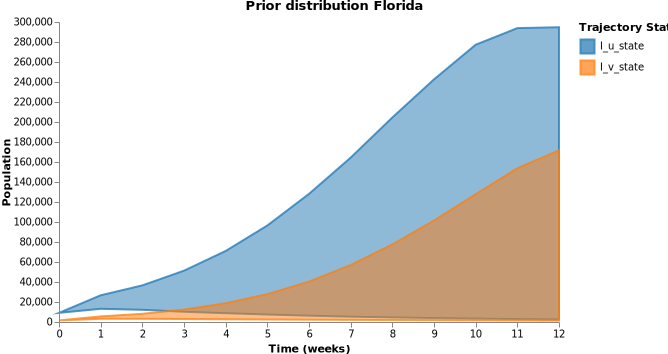

In [ ]:
result1 = pyciemss.sample(model, end_time, logging_step_size, num_samples, start_time=start_time)
# display(result1['data'].head())

# Plot infectious states
schema = plots.trajectories(result1["data"], keep="I.*", title=[f"Prior distribution {state_dict['state_name'][state_num]}"], axis_labels={"xaxis_label": "Time (weeks)", "yaxis_label": "Population"})
plots.save_schema(schema, "_schema.svg")
plots.ipy_display(schema, format='svg') 

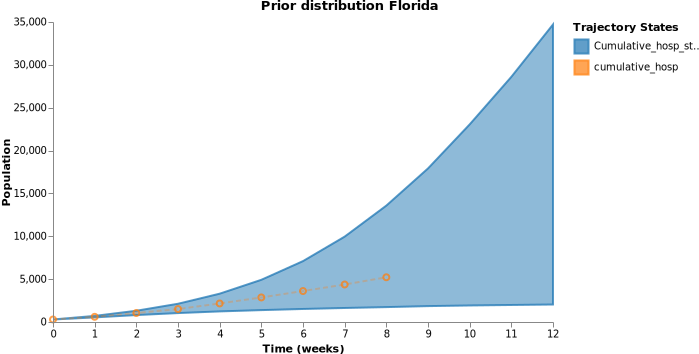

In [124]:
# Plot cumulative hospitalizations with data
dataset = state_dict['dataset'][state_num]
schema = plots.trajectories(result1["data"], keep="Cumulative_hosp_state", points=dataset.reset_index(drop=True), title=[f"Prior distribution {state_dict['state_name'][state_num]}"], axis_labels={"xaxis_label": "Time (weeks)", "yaxis_label": "Population"})
plots.save_schema(schema, "_schema.svg")
plots.ipy_display(schema, format='svg') 

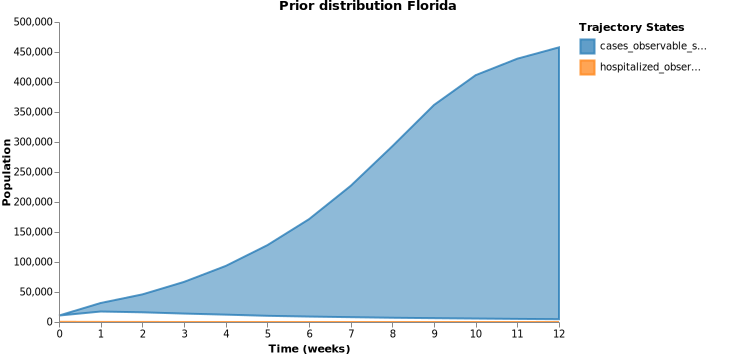

In [ ]:
# Plot all states for sanity check (no negative values)
schema = plots.trajectories(result1["data"], keep=".*_state", title=[f"Prior distribution {state_dict['state_name'][state_num]}"], axis_labels={"xaxis_label": "Time (weeks)", "yaxis_label": "Population"})
plots.save_schema(schema, "_schema.svg")
plots.ipy_display(schema, format='svg') 

# Set up and perform calibration

In [126]:
dataset

,cumulative_hosp
Timestamp,
0.0,292
1.0,605
2.0,1049
3.0,1511
4.0,2163
5.0,2864
6.0,3612
7.0,4375
8.0,5219


In [127]:
data_mapping = {"cumulative_hosp": "Cumulative_hosp"}
dataset = state_dict['dataset'][state_num]

num_iterations = 100
calibrated_results = pyciemss.calibrate(
    model, 
    dataset, 
    data_mapping=data_mapping, 
    num_iterations=num_iterations
)
parameter_estimates = calibrated_results["inferred_parameters"]
parameter_estimates()

ERROR:root:
                ###############################

                There was an exception in pyciemss

                Error occured in function: calibrate

                Function docs : 
    Infer parameters for a DynamicalSystem model conditional on data.
    This uses variational inference with a mean-field variational family to infer the parameters of the model.

    Args:
        - model_path_or_json: Union[str, Dict]
            - A path to a AMR model file or JSON containing a model in AMR form.
        - data_path: str
            - A path to the data file.
        - data_mapping: Dict[str, str]
            - A mapping from column names in the data file to state variable names in the model.
                - keys: str name of column in dataset
                - values: str name of state/observable in model
            - If not provided, we will assume that the column names in the data file match the state variable names.
        - noise_model: str
            - The 

ValueError: The first column must be named 'Timestamp' and contain the time corresponding to each row of data.

### Simulate calibrated model and 4-week forecast, plot results with data

In [ ]:
calibrated_sample_results = pyciemss.sample(
    model, 
    end_time, 
    logging_step_size, 
    num_samples,             
    start_time=start_time, 
    inferred_parameters=parameter_estimates
)
# display(calibrated_sample_results["data"].head())

# Plot the result
schema = plots.trajectories(calibrated_sample_results["data"], keep="Cumulative_hosp_state", points=dataset.reset_index(drop=True), title=[f"Calibrated distribution {state_dict['state_name'][state_num]}"], axis_labels={"xaxis_label": "Time (weeks)", "yaxis_label": "Population"})
plots.save_schema(schema, "_schema.svg")
plots.ipy_display(schema, format='svg') 